In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

# Load Data

In [2]:
#read user engagement csv
df_engagement = pd.read_csv('takehome_user_engagement.csv')
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
#read user csv
df_users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Let's explore the unix time code used in last_session_creation_time.

We need to check to see what time zone the times are recorded in.

In [4]:
#convert timestamp to UTC time
datetime.datetime.utcfromtimestamp(df_users.loc[0,'last_session_creation_time']).strftime('%Y-%m-%d %H:%M:%S')

'2014-04-22 03:53:30'

In [5]:
#convert timestamp in local time
datetime.datetime.fromtimestamp(df_users.loc[0,'last_session_creation_time']).strftime('%Y-%m-%d %H:%M:%S')

'2014-04-21 23:53:30'

It does not make sense for the last session creation time to occur before the creation time.  This informs us that the time recorded in UTC time.

In [6]:
#convert last_seession_creation_time column to UTC datetime
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit = 's')

#convert creation_time to datetime
df_users.creation_time = pd.to_datetime(df_users.creation_time)

#convert time_stamp to datetime
df_engagement.time_stamp = pd.to_datetime(df_engagement.time_stamp)

In [7]:
#rename object_id column to user_id
df_users.rename(columns = {'object_id':'user_id'}, inplace=True)


# Identify Active Users

In [8]:
df_engagement.sort_values(['user_id', 'time_stamp'], inplace=True)

In [9]:
df_engagement_grouped = df_engagement.groupby('user_id')

In [10]:
#get list of user_ids and number of sessions created
df_count = pd.DataFrame(df_engagement.user_id.value_counts().sort_index())

In [11]:
df_count.head()

,user_id
1,1
2,14
3,1
4,1
5,1


In [12]:
#get a list of the users who have created more than 3 sessions in total
df_active = df_count[df_count.user_id >= 3]
user_list = list(df_active.index)
df_active.head()

,user_id
2,14
10,284
20,7
33,18
42,342


To consider a user as active, they need to have created a session 3 times within a week, and each session must be at least 1 day apart.

In [13]:
def active(a):
    #checks that the delta between two timestamps is less than 7 days (1 week)
    #also checks that the delta between any 2 timestamps is more than 1 day
    if (a['shift2'] - a['time_stamp'] <= datetime.timedelta(days=7)) and (a['shift1'] - a['shift2'] >= datetime.timedelta(days=1)) and (a['shift1'] - a['time_stamp'] >= date.timedelta(days=1)):
        return 1
    else:
        return 0

In [14]:
temp_list = []
#uses our previous list of users who created more than 3 sessions
for i in user_list:
    #get the total sessions for the user i
    temp = df_engagement_grouped.get_group(i)
    
    #shift datetimes up 1 row
    temp['shift1'] = temp.time_stamp.shift(-1)

    #shift datetimes up 2 rows
    temp['shift2'] = temp.time_stamp.shift(-2)
    #if the difference between 'shift' and 'time_stamp' is less than 7 days, give that row a value of 1
    temp['active'] = temp.apply(active, axis=1)
    temp_list.append(temp)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [15]:
#concat the dataframes for each user_id
df = pd.concat(temp_list)

If the sum of all the values in the active column are 0, then that particular user does not have any 7 day period where they have created 3 sessions, meaning they are not active and are assigned a value of 0.  If a user has at least one instance of being labelled as active, then they will be labelled as active in df_users with a value of 1.

In [16]:
#Create list of active users
active_list = list((df.groupby('user_id').active.sum() > 0).index)

In [17]:
df_users['active'] = df_users.user_id.apply(lambda x: 1 if x in active_list else 0)

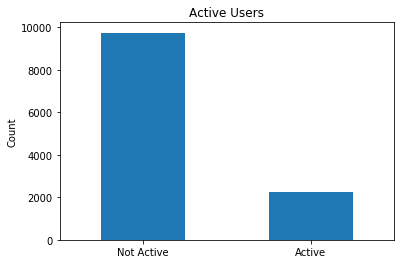

In [18]:
df_users.active.value_counts().plot(kind='bar', title='Active Users')
plt.xticks([0,1], labels=['Not Active', 'Active'], rotation=None)
plt.ylabel('Count')
plt.show()


Now that we have a column indicating if the user is active or not, let's clean up the rest of the data.

In [19]:
#check for null values
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
active                        12000 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(5), object(3)
memory usage: 1.0+ MB


The null values for the last_session_creation_time should be left as is since that means this user has yet to create a session.

invited_by_user_id NaN values should be set to 0, meaning no one invited this user since there is no user with a 0 user_id.

In [20]:
df_users.invited_by_user_id.fillna(0,inplace=True)
df_users.invited_by_user_id = df_users.invited_by_user_id.astype(int)

In [21]:
#create sessions column: the total number of sessions for a user_id
df_users['sessions'] = df_users.user_id.apply(lambda x: df_count.loc[x,'user_id'] if x in list(df_count.index) else 0)

In [22]:
#create number_of_days column: the number of days between the last session, and creation
df_users['number_of_days'] = df_users.apply(lambda x: (x['last_session_creation_time'] - x['creation_time']).days, axis=1)

In [23]:
#fill null values with 0
df_users['sessions'].fillna(0,inplace=True)
df_users['number_of_days'].fillna(0,inplace=True)

In [24]:
df_users.head(10)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,sessions,number_of_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,0,1,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,1,14,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,0,1,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,0,1,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,0,1,5.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241,0,1,2.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,0,0,1,4.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,0,0,0,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,0,0,0,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143,1,284,503.0


In [25]:
#encode the creation source
df_source = pd.get_dummies(df_users.creation_source)

In [26]:
#combine the encoded source data with columns from df_user
df_model = pd.concat([df_source, df_users[['opted_in_to_mailing_list','enabled_for_marketing_drip', 
                                           'org_id', 'invited_by_user_id', 'sessions', 
                                           'number_of_days', ]]], axis=1)

# Logistic Regression Model

In [27]:
from sklearn.model_selection import train_test_split

X = df_model
y = df_users.active

#create train, test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
y_pred = model.predict(X_test)

Since our target variable 'active' is a bit imbalanced, we should look at precision, recall, and f1 scores as metrics for model.

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('accuracy: %.3f'%accuracy_score(y_test, y_pred))
print('precision: %.3f'%precision_score(y_test, y_pred))
print('recall: %.3f'%recall_score(y_test, y_pred))
print('f1 score: %.3f'%f1_score(y_test, y_pred))

accuracy: 0.999
precision: 1.000
recall: 0.996
f1 score: 0.998


# Feature Importance

In [31]:
df_coef = pd.DataFrame({'feature':df_model.columns, 'coef':model.coef_[0]}).sort_values(by='coef', ascending=False).reset_index(drop=True)

In [32]:
df_coef

,feature,coef
0,sessions,3.003008
1,number_of_days,0.025632
2,invited_by_user_id,-0.000141
3,org_id,-0.003343
4,enabled_for_marketing_drip,-0.290008
5,opted_in_to_mailing_list,-0.351685
6,GUEST_INVITE,-0.649236
7,ORG_INVITE,-1.026492
8,SIGNUP_GOOGLE_AUTH,-1.376756
9,PERSONAL_PROJECTS,-1.381779


# Conclusion

From this preliminary model, we can see that the number of sessions a user_id has created, as well as the number of days between a user_id's first and last session created are the most important factors in predicting a user as being active or not.